# Noising Data to test how FAD is working

In [4]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import soundfile as sf

In [10]:
def add_noise_to_waveform(data, noise_level=0.2):
    """ Add random noise to the waveform """
    noise = np.random.randn(*data.shape) * noise_level
    distorted_data = data + noise
    return distorted_data

def process_audio_files(src_directory, dst_directory):
    """ Process all .wav files in the source directory and save them to the destination directory with added noise """
    if not os.path.exists(dst_directory):
        os.makedirs(dst_directory)
    
    for filename in tqdm(os.listdir(src_directory)):
        if filename.endswith('.wav'):
            src_path = os.path.join(src_directory, filename)
            dst_path = os.path.join(dst_directory, filename)
            
            # Read audio file
            data, samplerate = sf.read(src_path)
            
            # Add noise to the audio data
            distorted_data = add_noise_to_waveform(data)
            
            # Save the distorted audio file
            sf.write(dst_path, distorted_data, samplerate)

In [11]:
# Directories
source_directory = '../cache/spotify_sleep_dataset/waveform_small'
destination_directory = '../cache/spotify_sleep_dataset/waveform_small_distorted_2'

# Process the audio files
process_audio_files(source_directory, destination_directory)

100%|██████████| 103/103 [00:18<00:00,  5.70it/s]


# Viewing Mel Specs

In [25]:
import pyarrow.parquet as pq
import pickle
import torch
from datasets import load_dataset, load_from_disk
from torchvision.transforms import Compose, Normalize, ToTensor

In [27]:
def load_dataset(dataset_path):
    dataset_name = '../cache/spotify_sleep_dataset/waveform_small/mel_spectrogram_256_256'
    dataset_config_name = None
    vae = None

    dataset = load_from_disk(
        dataset_name,
        storage_options=dataset_config_name)["train"]
    
    train_batch_size = 16

    # Determine image resolution
    resolution = dataset[0]["image"].height, dataset[0]["image"].width

    augmentations = Compose([
        ToTensor(),
        Normalize([0.5], [0.5]),
    ])

    vqvae = None
    def transforms(examples):
        if vae is not None and vqvae.config["in_channels"] == 3:
            images = [
                augmentations(image.convert("RGB"))
                for image in examples["image"]
            ]
        else:
            images = [augmentations(image) for image in examples["image"]]
        if encodings is not None:
            encoding = [encodings[file] for file in examples["audio_file"]]
            return {"input": images, "encoding": encoding}
        return {"input": images}

    dataset.set_transform(transforms)
    train_dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=train_batch_size, shuffle=True)

    encodings = None
    if encodings is not None:
        encodings = pickle.load(open(encodings, "rb"))
        
    return dataset


In [28]:
dataset_name = '../cache/spotify_sleep_dataset/waveform_small/mel_spectrogram_256_256'
dataset = load_dataset(dataset_name)

In [29]:
dataset

Dataset({
    features: ['image', 'audio_file', 'slice'],
    num_rows: 402
})

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

In [23]:
def show_image(index):
    # Access the image at the specified index
    item = dataset[index]
    # Convert the tensor image to a PIL image
    image_tensor = item["input"].squeeze(0)  # Remove batch dimension if present
    
    # Check if the image tensor has 3 dimensions (C, H, W)
    if image_tensor.dim() == 3:
        # Permute the dimensions to (H, W, C)
        image_tensor = image_tensor.permute(1, 2, 0)
    else:
        # Add an extra dimension to mimic grayscale as RGB (for consistent handling)
        image_tensor = image_tensor.unsqueeze(2).repeat(1, 1, 3)

    # Denormalize the image tensor
    image_tensor = (image_tensor * 0.5 + 0.5) * 255
    image = Image.fromarray(image_tensor.numpy().astype('uint8'))
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()


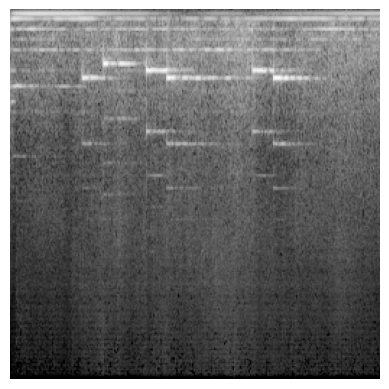

In [24]:
show_image(0)